In [132]:
%load_ext autoreload
%autoreload 2
from pentropy_main import *
import itertools
import json
from collections import Counter,defaultdict


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
def classify_vars(variables, N, K):
    classification = defaultdict(lambda: defaultdict(list))
    unclassified_vars = []
    
    for entropy in variables:
        # 统计W/X/Z数量
        w_count = sum(1 for e in entropy if e.startswith('W'))
        x_count = sum(1 for e in entropy if e.startswith('X'))
        z_count = sum(1 for e in entropy if e.startswith('Z'))
        primary_key = (w_count, x_count, z_count)
        
        if x_count > 0:
            unclassified_vars.append(entropy)
            continue
        # 处理需求类型
        # if x_count > 0:
        #     type_counter = Counter()
        #     for elem in entropy:
        #         if elem.startswith('X'):
        #             # 解析文件需求模式
        #             demands = [0] * N
        #             for c in elem[1:]:
        #                 idx = int(c) - 1
        #                 # if idx < N:
        #                 demands[idx] += 1
        #             sorted_demand = tuple(sorted(demands, reverse=True)) # 倒序排列需求量
        #             type_counter[sorted_demand] += 1
        #     secondary_key = tuple(sorted(type_counter.items()))    
        # else:
        #     secondary_key = None
        secondary_key = None
        entropy_str = ",".join(sorted(entropy,key=Iutils.sort_key))
        classification[primary_key][secondary_key].append(entropy_str)
    # print("unclassified",unclassified_vars)
    # print(len(unclassified_vars))
    
    # 生成熵字典
    entropydict = EntropyEqDict()
    current_index = 0
    for primary in classification:
        if primary[1] == 0 or (primary[0] == 0 and primary[0] == 0):
            for secondary in classification[primary]:
                # 对每个分组内的元素进行排序后转换为字符串
                classification[primary][secondary] = Iutils.sort_elements(classification[primary][secondary])
                for item in classification[primary][secondary]:
                    # print("item",item)
                    if entropydict.get(item) is None:
                        entropydict[item] = current_index
                current_index += 1
    
    return entropydict,unclassified_vars

In [134]:
def replace_by_userindex(s, user_perms):
        # Step 1: Remove all non-alphanumeric characters except commas
        # s = re.sub(r"[^a-zA-Z0-9,]", "", s)

        # Step 2: Split the input string by commas
        elements = s.split(",")

        # Step 3: Generate all possible permutations of the numbers
        permutations = user_perms
        # print("permutations", permutations)

        # Step 4: Apply each permutation to the original string
        results = []
        for perm in permutations:
            perm_dict = {str(i + 1): str(perm[i]) for i in range(len(perm))}
            new_elements = []
            for e in elements:
                if e.startswith("Z"):
                    prefix = e[0]
                    number = "".join(filter(str.isdigit, e))
                    new_number = "".join(perm_dict[digit] for digit in number)
                    new_elements.append(prefix + new_number)
                elif e.startswith("X"):
                    prefix = e[0]
                    number = "".join(filter(str.isdigit, e))
                    # new_number = "".join(number[perm[i] - 1] for i in range(len(perm)))
                    new_number = [''] * len(number)
                    for i in range(len(perm)):
                        new_index = int(perm_dict[str(i + 1)]) - 1
                        new_number[new_index] = number[i]
                    new_number = ''.join(new_number)
                    # if perm == (3,1,2) and s == "W1,X112,Z1":
                    #     print("new_number",new_number)
                    new_elements.append(prefix + new_number)
                else:
                    new_elements.append(e)
            results.append(",".join(new_elements))

        return results

In [135]:
def get_permutations(indices, N):
    
    perms = []
    base_list = [0] * N 
    
    # 将 indices 位置的元素依次设为 1, 2, 3, ...
    ori_perms = itertools.permutations(range(1, len(indices) + 1), len(indices))
    for ori_perm in ori_perms:
        for idx,value in zip(indices,ori_perm):
            base_list[idx-1] = value
        # 获取其余位置的索引
        remaining_pos = [i for i in range(N) if i+1 not in indices]
        # print("remain position",remaining_pos)
        
        # 对剩余位置进行 (N - len(W_indices)) 范围内的任意排列组合
        # 对填充内容进行排列组合
        remaining_permutations = itertools.permutations(range(len(indices)+1, N+1), len(remaining_pos))  
        
        # 将每种排列组合填入剩余位置
        for perm in remaining_permutations:
            # print("perm",perm)
            temp_list = base_list[:]
            for pos, value in zip(remaining_pos, perm):
                temp_list[pos] = value
            perms.append(temp_list)
    
    return perms


In [136]:
def replace_by_fileindex(s, file_perms):
        # Step 1: Split the input string by commas
        elements = s.split(",")

        # Step 2: Generate all possible permutations of the numbers
        # permutations = list(itertools.permutations(range(1, N + 1)))
        permutations = file_perms

        results = []

        # Step 3: Apply each permutation to the original string
        for perm in permutations:
            perm_dict = {str(i + 1): str(perm[i]) for i in range(len(perm))}
            new_elements = []
            for e in elements:
                if e.startswith("W") or e.startswith("X"):
                    prefix = e[0]
                    number = "".join(filter(str.isdigit, e))
                    new_number = "".join(perm_dict[digit] for digit in number)
                    new_elements.append(prefix + new_number)
                else:
                    new_elements.append(e)
            results.append(",".join(new_elements))
        return results

In [137]:
def replace_by_combined_rules(s, user_perms, file_perms):
        # Step 1: Get all results from replace_by_userindex
        userindex_results = replace_by_userindex(s, user_perms)
        userindex_results = list(set(userindex_results))
        # print("userindex_results", userindex_results)

        # Step 2: Apply replace_by_fileindex to each result from replace_by_userindex
        final_results = set()  # Use a set to store unique results
        for result in userindex_results:
            fileindex_results = replace_by_fileindex(result, file_perms)
            # print("fileindex_results", fileindex_results)
            for fileindex_result in fileindex_results:
                # Normalize the result by sorting the elements
                elements = fileindex_result.split(",")
                sorted_elements = ",".join(sorted(elements, key=Iutils.sort_key))

                final_results.add(sorted_elements)
        final_results.add(s)
        
        # Step 3: Sort the final results
        sorted_results = Iutils.sort_elements(list(final_results))

        return sorted_results

In [138]:
def symmetrize(N, K, expand_vars, entropydict):
    print("symmetrize")
    s = time.perf_counter()
    symentropy = []
    same_ent = 0
    index = len(entropydict.redict)
    # print("index",index)
    # entropydict, unclassified_vars = classify_vars(expand_vars, N, K)
    for item in expand_vars:
        # print(index)
        # print("item",item)
        W_indices = [int(elem[1]) for elem in item if elem.startswith("W")]
        Z_indices = [int(elem[1]) for elem in item if elem.startswith("Z")]
        file_perms = Iutils.get_permutations(W_indices, N)
        # print("file_perms",file_perms)
        user_perms = Iutils.get_permutations(Z_indices, K)
        # print("user_perms",user_perms)
        item_key = ','.join(sorted(item, key=Iutils.sort_key))
        # 对没有进行处理的联合变量进行处理
        if entropydict.get(item_key) is None:
            # print("item_key",item_key)
            symmetricentropy = Iutils.replace_by_combined_rules(item_key, user_perms, file_perms) 
            # print("symmetricentropy",symmetricentropy)
            # symentropy.append(symmetricentropy[0])
            same_ent -= 1
            if entropydict.get(symmetricentropy[0]) is None:
                # print("1")
                for symitem in symmetricentropy:
                    # print(symitem)
                    entropydict[symitem] = index
                    same_ent += 1
                index += 1
            else:
                # print("0")
                entropydict[item_key] = entropydict[symmetricentropy[0]]
                same_ent += 1
    e = time.perf_counter()
    t = e - s
    print(f"symmetrize time:{t}")
    print("number of varibles",len(entropydict.redict))
    return

In [139]:
# define parameters
N = 4
K = 4
point_num = 18
user_perm = list(itertools.permutations(range(1, K + 1)))
file_perm = list(itertools.permutations(range(1, N + 1)))

# generate all random variables
allrvs = []
Wrvs = []
W_combinations = []
for i in range(1, N+1):
    allrvs.append("W" + str(i))
    Wrvs.append("W" + str(i))
for i in range(1, K+1):
    allrvs.append("Z" + str(i))

X_combinations = ["X" + item for item in Iutils.generate_combinations(N, K)]
if N == 3 and K == 3:
    X_combinations = ["X112","X113","X123"]
elif N == 2 and K == 4:
    X_combinations = ["X1112","X1122"]
elif N == 4 and K == 2:
    X_combinations = ["X12","X13","X14"]
elif N == 4 and K == 3:
    X_combinations = ["X112","X113","X114","X123"]
elif N == 4 and K == 4:
    X_combinations = ["X1112","X1123","X1234"]
elif N == 4 and K == 5:
    X_combinations = ["X11112","X11123","X11234"]
elif N == 5 and K == 4:
    X_combinations = ["X1112","X1123","X1234"]
elif N == 6 and K == 4:
    X_combinations = ["X1112","X1123","X1234"]
elif N == 5 and K == 5:
    X_combinations = ["X11112","X11123","X11234","X12345"]

Xrvs_cons = Iutils.symmetry_vars(user_perm,file_perm,X_combinations)
# 生成W约束
for r in range(N+1):
    # 生成指定长度的所有组合
    combos = itertools.combinations(Wrvs, r+1)
    for combo in combos:
        W_combinations.append(list(combo))
for item in X_combinations:
    allrvs.append(item)

Wrvs_cons = Iutils.symmetry_vars(user_perm,file_perm,W_combinations)
Wkey = ','.join(sorted(Wrvs, key=Iutils.sort_key))
# allrvs = Ivar.rv(allrvs)
print(len(allrvs))
print(allrvs)

11
['W1', 'W2', 'W3', 'W4', 'Z1', 'Z2', 'Z3', 'Z4', 'X1112', 'X1123', 'X1234']


In [140]:
# generate all joint entropies
allentropy = []
for r in range(1, len(allrvs) + 1):
    subsets = itertools.combinations(allrvs, r)
    for subset in subsets:
        # Step 2: Join the elements of each subset with a comma
        allentropy.append(list(subset))
        
print(len(allentropy))
# print(allentropy)

2047


In [141]:
# entropydict, unclassified_vars = classify_vars(allentropy,N,K)

entropydict = EntropyEqDict()
entropydict_all = EntropyEqDict()
# print(entropydict)


In [142]:
# print(unclassified_vars)

In [143]:
# symmetrize(N,K,unclassified_vars,entropydict,Xrvs_cons,Wrvs_cons)
# Iutils.symmetrize_simple(N,K,allentropy,entropydict)
Iutils.symmetrize_by_dict_simple(N,K,allentropy,entropydict_all)

get:0,time:0
not get:2047,time:3.162850399821764


In [144]:
# symm = set()
# # print(entropydict.redict.items())
# for _,var in entropydict.redict.items():
#     # print(var)
#     symm.add(var[0])
# print(symm)
# print(len(symm))

In [145]:
Iutils.problem_constraints_process(N,K,Wkey,entropydict_all)
entropydict_all.regenerate_keys()

for var in allentropy:
    var_str = ",".join(sorted(var,key=Iutils.sort_key))
    entropydict[var_str] = entropydict_all.get(var_str)
entropydict.regenerate_keys()

In [146]:
print(len(entropydict.redict))

266


In [147]:
# print(entropydict.eqdict)

In [148]:
print(entropydict.redict)

{0: ['W1', 'W2', 'W3', 'W4'], 1: ['Z1', 'Z2', 'Z3', 'Z4'], 2: ['X1112'], 3: ['X1123'], 4: ['X1234'], 5: ['W1,W2', 'W1,W3', 'W1,W4', 'W2,W3', 'W2,W4', 'W3,W4'], 6: ['W1,Z1', 'W1,Z2', 'W1,Z3', 'W1,Z4', 'W2,Z1', 'W2,Z2', 'W2,Z3', 'W2,Z4', 'W3,Z1', 'W3,Z2', 'W3,Z3', 'W3,Z4', 'W4,Z1', 'W4,Z2', 'W4,Z3', 'W4,Z4'], 7: ['W1,X1112'], 8: ['W1,X1123'], 9: ['W1,X1234', 'W2,X1234', 'W3,X1234', 'W4,X1234'], 10: ['W2,X1112'], 11: ['W2,X1123', 'W3,X1123'], 12: ['W3,X1112', 'W4,X1112'], 13: ['W4,X1123'], 14: ['Z1,Z2', 'Z1,Z3', 'Z1,Z4', 'Z2,Z3', 'Z2,Z4', 'Z3,Z4'], 15: ['Z1,X1112', 'Z2,X1112', 'Z3,X1112', 'W1,Z1,X1112', 'W1,Z2,X1112', 'W1,Z3,X1112'], 16: ['Z1,X1123', 'Z2,X1123', 'W1,Z1,X1123', 'W1,Z2,X1123'], 17: ['Z1,X1234', 'Z2,X1234', 'Z3,X1234', 'Z4,X1234', 'W1,Z1,X1234', 'W2,Z2,X1234', 'W3,Z3,X1234', 'W4,Z4,X1234'], 18: ['Z3,X1123', 'Z4,X1123', 'W2,Z3,X1123', 'W3,Z4,X1123'], 19: ['Z4,X1112', 'W2,Z4,X1112'], 20: ['X1112,X1123'], 21: ['X1112,X1234'], 22: ['X1123,X1234'], 23: ['W1,W2,W3', 'W1,W2,W4', 'W

In [149]:
regions = Region.empty()
Iutils.generate_inequalities(allentropy,allrvs,entropydict,regions)

In [150]:
print(len(regions.exprs))
for expr in regions.exprs:
    expr.sort_terms()
    print(expr)

4657
2H({W1}) - H({W1,W2}) >= 0
2H({W1,W2}) - H({W1}) - H({W1,W2,W3}) >= 0
2H({W1,Z1}) - H({Z1}) - H({W1,W2,Z1}) >= 0
H({W1,X1112}) + H({W2,X1112}) - H({X1112}) - H({W1,W2,X1112}) >= 0
H({W1,X1123}) + H({W2,X1123}) - H({X1123}) - H({W1,W2,X1123}) >= 0
2H({W1,X1234}) - H({X1234}) - H({W1,W2,X1234}) >= 0
2H({W1,W2,W3}) - H({W1,W2}) - H({W1,W2,W3,W4}) >= 0
2H({W1,W2,Z1}) - H({W1,Z1}) - H({W1,W2,W3,Z1}) >= 0
H({W1,W3,X1112}) + H({W2,W3,X1112}) - H({W3,X1112}) - H({W1,W2,W3,X1112}) >= 0
H({W1,W2,X1123}) + H({W2,W3,X1123}) - H({W2,X1123}) - H({W1,W2,W3,X1123}) >= 0
2H({W1,W2,X1234}) - H({W1,X1234}) - H({W1,W2,W3,X1234}) >= 0
H({W1,W4,X1123}) + H({W2,W4,X1123}) - H({W4,X1123}) - H({W1,W2,W4,X1123}) >= 0
2H({W1,Z1,Z2}) - H({Z1,Z2}) - H({W1,W2,Z1,Z2}) >= 0
2H({W1,Z2,X1234}) - H({Z1,X1234}) - H({W1,W2,Z3,X1234}) >= 0
H({W1,Z3,X1123}) + H({W2,Z4,X1123}) - H({Z3,X1123}) - H({W1,W2,Z4,X1123}) >= 0
H({W1,X1112,X1123}) + H({W2,X1112,X1123}) - H({X1112,X1123}) - H({W1,W2,X1112,X1123}) >= 0
H({W1,X1112

In [151]:
# simplify the inequalities
regions.reduce_redundant_expr()
print(len(regions.exprs))
for expr in regions.exprs:
    print(expr)

4649
2H({W1}) - H({W1,W2}) >= 0
2H({W1,W2}) - H({W1}) - H({W1,W2,W3}) >= 0
2H({W1,Z1}) - H({Z1}) - H({W1,W2,Z1}) >= 0
H({W1,X1112}) + H({W2,X1112}) - H({X1112}) - H({W1,W2,X1112}) >= 0
H({W1,X1123}) + H({W2,X1123}) - H({X1123}) - H({W1,W2,X1123}) >= 0
2H({W1,X1234}) - H({X1234}) - H({W1,W2,X1234}) >= 0
2H({W1,W2,W3}) - H({W1,W2}) - H({W1,W2,W3,W4}) >= 0
2H({W1,W2,Z1}) - H({W1,Z1}) - H({W1,W2,W3,Z1}) >= 0
H({W1,W3,X1112}) + H({W2,W3,X1112}) - H({W3,X1112}) - H({W1,W2,W3,X1112}) >= 0
H({W1,W2,X1123}) + H({W2,W3,X1123}) - H({W2,X1123}) - H({W1,W2,W3,X1123}) >= 0
2H({W1,W2,X1234}) - H({W1,X1234}) - H({W1,W2,W3,X1234}) >= 0
H({W1,W4,X1123}) + H({W2,W4,X1123}) - H({W4,X1123}) - H({W1,W2,W4,X1123}) >= 0
2H({W1,Z1,Z2}) - H({Z1,Z2}) - H({W1,W2,Z1,Z2}) >= 0
2H({W1,Z2,X1234}) - H({Z1,X1234}) - H({W1,W2,Z3,X1234}) >= 0
H({W1,Z3,X1123}) + H({W2,Z4,X1123}) - H({Z3,X1123}) - H({W1,W2,Z4,X1123}) >= 0
H({W1,X1112,X1123}) + H({W2,X1112,X1123}) - H({X1112,X1123}) - H({W1,W2,X1112,X1123}) >= 0
H({W1,X1112

In [152]:
# construct the constranits matrix
ine_constraints = []
ent_num = len(entropydict.redict) + 3
for expr in regions.exprs:
    row = [0] * ent_num
    for term in expr.terms:
        row[entropydict[term.to_ent_str()]] = term.coef
    row[-1] = expr.value
    ine_constraints.append(row)

In [153]:
def AddProblemConstraints2Matrix(Xrvs_cons, Wrvs_cons, entropydict, ine_constraints, ent_num):
    # R >= H(X)
    prob_cons_num = 0
    for key in Xrvs_cons:
        if entropydict.get(key) != None:
            row3 = [0] * ent_num
            row3[entropydict[key]] = -1
            row3[-2] = 1
            ine_constraints.append(row3)
            prob_cons_num += 1

    # M >= H(Z)
    row5 = [0] * ent_num
    row5[entropydict["Z1"]] = -1
    row5[-3] = 1
    ine_constraints.append(row5)
    prob_cons_num += 1

    # H(W1,..,Wn) >= n
    for key in Wrvs_cons:
        if entropydict.get(key) != None:
            rvs = key.split(",")
            row3 = [0] * ent_num
            row3[entropydict[key]] = 1
            row3[-1] = len(rvs)
            # print(row3)
            ine_constraints.append(row3)
            prob_cons_num += 1

    # M = M_value
    row5 = [0] * ent_num
    ine_constraints.append(row5)

    return ine_constraints, prob_cons_num

In [154]:
# # additional constraints
# # R >= H(X)
# prob_cons_num = 0
# for key in Xrvs_cons:
#     if entropydict.get(key) != None:
#         row3 = [0] * ent_num
#         row3[entropydict[key]] = -1
#         row3[-2] = 1
#         ine_constraints.append(row3)
#         prob_cons_num += 1

# # M >= H(Z)
# row5 = [0] * ent_num
# row5[entropydict["Z1"]] = -1
# row5[-3] = 1
# ine_constraints.append(row5)
# prob_cons_num += 1

# # H(W1,..,Wn) >= n
# for key in Wrvs_cons:
#     if entropydict.get(key) != None:
#         rvs = key.split(",")
#         row3 = [0] * ent_num
#         row3[entropydict[key]] = 1
#         row3[-1] = len(rvs)
#         # print(row3)
#         ine_constraints.append(row3)
#         prob_cons_num += 1

# row5 = [0] * ent_num
# ine_constraints.append(row5)


In [155]:
ine_constraints, prob_cons_num = AddProblemConstraints2Matrix(Xrvs_cons, Wrvs_cons, entropydict, ine_constraints, ent_num)

In [156]:
ine_constraints = np.array(ine_constraints)
print(ine_constraints.shape)
ine_constraints = ine_constraints.astype(np.float64)
delete_row = [242,252]
# ine_constraints = np.delete(ine_constraints, delete_row, axis=0)
expr_num = ine_constraints.shape[0] - 1 # 不等式数量
ent_num = ine_constraints.shape[1] - 1 # 减之前用于生成矩阵，减之后就是实际的熵变量数量

ori_obj_coef = np.zeros(ent_num)
ori_obj_coef[-1] = 1

(4658, 269)


In [157]:
# original problem solver
from gurobipy import Model, GRB, LinExpr, GurobiError
import gurobipy as gp

def gurobi_solver():
    try:
        global effective_idx_gurobi
        global ori_obj_coef
        ine_list = []
        # global result_slope
        # 创建 Gurobi 模型
        model = Model("entropy_minimization")

        # 禁用输出日志（可选）
        model.setParam("OutputFlag", 0)

        # 创建变量
        variables = []
        for i in range(ent_num):
            var = model.addVar(name=f"V{i}", lb=0)
            variables.append(var)
        obj_expr = gp.quicksum(ori_obj_coef * variables)
        model.setObjective(obj_expr, GRB.MINIMIZE)
        # model.setObjective(variables[-1], GRB.MINIMIZE)
        # var_names = ["V" + str(i) for i in range(ent_num)]
        # variables = model.addVars(var_names, lb=0, obj=[0.0] * (ent_num), name="V")
        # variables[var_names[-1]].obj = 1.0  # 设置目标函数的系数
        # model.setObjective(variables[var_names[-1]], GRB.MINIMIZE)

        # 添加不等式约束
        for ine in ine_constraints[:-1]:
            model.addConstr(LinExpr(ine[:-1], variables) >= ine[-1])

        # 添加等式约束 M = M_value
        M_cons = ine_constraints[-1]
        model.addConstr(LinExpr(M_cons[:-1], variables) == M_cons[-1])
        # 添加等式约束 M = M_value
        # model.addConstr(variables[var_names[-2]] == M_value)

        model.optimize()

        # 检查求解状态
        if model.status == GRB.OPTIMAL:
            dual_values = model.getAttr('Pi', model.getConstrs())

            indices = [i for i, val in enumerate(dual_values) if abs(val) > 1e-5 and i < len(regions.exprs)]
            # slope = dual_values[-1]
            # result_slope.append(slope)

            for index in indices:
                if index not in effective_idx_gurobi:
                    effective_idx_gurobi.append(index)
                    effective_idx_gurobi.sort()
            
            # 获取目标函数值
            optimal_value = model.objVal
            print(f"Optimal value: {optimal_value}")
        
            return optimal_value
        elif model.status == GRB.INFEASIBLE:
            print("Model is infeasible. Trying to find the IIS...")
            model.computeIIS()
            model.write("model.ilp")
            print("IIS written to model.ilp. Check this file for conflicting constraints.")
            for c in model.getConstrs():
                if c.IISConstr:
                    print(f"约束 {c.constrName} 导致不可行")
                    ine_list.append(c.constrName)
            for v in model.getVars():
                if v.IISLB or v.IISUB:
                    print(f"变量 {v.varName} 的边界条件导致不可行")
            return ine_list
        else:
            print(f"Model status: {model.status}")
            return None
    except GurobiError as e:
        print(f"Gurobi Error: {e}")
        return None


In [158]:
def dual_solver():
    try:
        global expr_num
        global dual_obj_coef
        global trans_ine_cons
        effective_idx_dual = []
        # 创建 Gurobi 模型
        model = Model("secondary LP")

        # 启用输出日志
        model.setParam("OutputFlag", 0)

        # 创建变量
        variables = []
        for i in range(expr_num):
            var = model.addVar(name=f"Y{i}", lb=0)
            variables.append(var)
        var_z = model.addVar(name="Z",lb=-GRB.INFINITY, ub=GRB.INFINITY)
        variables.append(var_z)
        # print("expr_num",expr_num)
        # print("len_var",len(variables))
        # objective_expr = gp.quicksum(coef_dual[i] * variables[i] for i in range(expr_num)) + M_value * variables[-1]
        objective_expr = gp.quicksum(dual_obj_coef * variables)
        # objective_expr = gp.quicksum(variables)
        model.setObjective(objective_expr, GRB.MAXIMIZE)

        # 添加不等式约束
        for ine in trans_ine_cons:
            model.addConstr(LinExpr(ine[:-1], variables) == ine[-1])

        # 添加等式约束 M = M_value
        # model.addConstr(variables[-1] == M_value)

        model.optimize()

        # 检查求解状态
        if model.status == GRB.OPTIMAL:
            # 获取目标函数值
            optimal_value = model.objVal
            # print(f"Optimal value: {optimal_value}")

            # 获取变量的最优解
            solution_values = {var.varName: var.x for var in model.getVars()}
            # print(f"Solution: {solution_values}")

            for var_name, var_value in solution_values.items():
                if var_value > 0:
                    index = int(var_name[1:])
                    if index < expr_num - prob_cons_num and index is not None:
                        effective_idx_dual.append(index)
            return solution_values, effective_idx_dual
        elif model.status == GRB.INFEASIBLE:
            print("Model is infeasible. Trying to find the IIS...")
            model.computeIIS()
            model.write("model.ilp")
            print("IIS written to model.ilp. Check this file for conflicting constraints.")
            return None,None
        else:
            print(f"Model status: {model.status}")
            return None,None
    except GurobiError as e:
        print(f"Gurobi Error: {e}")
        return None,None

In [159]:
def find_min_effective_indices(dual_value):
    non_zero_counts = np.count_nonzero(dual_value, axis=1)
    single_cut_idx = []
    all_cut_idx = set()
    if len(dual_value) == 0:
        return []
    
    old_slope = round(dual_value[0][-1],3)
    min_row = 0
    min_cnt = non_zero_counts[0]
    cnt = 0
    for idx, row in enumerate(dual_value):
        # 当检测到斜率变化时处理前一个分段
        if round(row[-1],3) != old_slope:
            cnt += 1
            print(cnt)
            count_dict = {}
            current_slope = old_slope  # 保存前一分段的斜率
            # 收集前一分段的最小行非零索引
            single_cut_idx = []
            for i, value in enumerate(dual_value[min_row]):
                if value > 0 and i < len(regions.exprs):
                    single_cut_idx.append(i)
            
            print(f"分段斜率: {current_slope}\n有效索引: {len(single_cut_idx)},{single_cut_idx}")
            
            # 处理约束条件（保持原逻辑）
            effective_constraints = [ine_constraints[i] for i in single_cut_idx]
            for constraint in effective_constraints:
                terms = []
                for i in range(len(constraint) - 1):
                    coef = constraint[i]
                    if coef != 0:
                        term_x = entropydict.get_keys_by_value(i)
                        if term_x:
                            term_x = term_x[0]
                            count_dict[term_x] = count_dict.get(term_x, 0) + 1
                            term_x = Comp.jes(term_x)
                            terms.append(Term(x=[term_x.copy()], coef=int(coef), termtype=TermType.H))
                expr = Expr(terms, eqtype="ge", value=constraint[-1])
                expr.sort_terms()
                new_regions.append_expr(expr)
                print(expr)
            print(f"有效变量数量:{len(count_dict)}")
            count_dict = sorted(count_dict.items(), key=lambda item: item[1],reverse=True)
            count_dict = dict(count_dict)
            print(count_dict)
            if cnt == 1:
                count_dict_all = count_dict.copy()
                # print("all",count_dict_all)
            else:
                count_dict_all = Counter(count_dict_all)
                count_dict_all.update(count_dict)
                count_dict_all = dict(count_dict_all)
                # print("all",count_dict_all)
            all_cut_idx.update(single_cut_idx)
            
            # 初始化新分段
            old_slope = round(row[-1],3)     # 更新为当前行的新斜率
            min_cnt = non_zero_counts[idx]
            min_row = idx
            single_cut_idx = []
        
        # 更新当前分段的最小行
        else:
            if non_zero_counts[idx] < min_cnt:
                min_cnt = non_zero_counts[idx]
                min_row = idx

    # 处理最后一个分段
    single_cut_idx = []
    count_dict = {}
    for i, value in enumerate(dual_value[min_row]):
        if value > 0 and i < len(regions.exprs):
            single_cut_idx.append(i)
    cnt += 1
    print(cnt)
    print(f"分段斜率: {old_slope}\n有效索引: {len(single_cut_idx)},{single_cut_idx}")
    
    effective_constraints = [ine_constraints[i] for i in single_cut_idx]
    for constraint in effective_constraints:
        terms = []
        for i in range(len(constraint) - 1):
            coef = constraint[i]
            if coef != 0:
                term_x = entropydict.get_keys_by_value(i)
                if term_x:
                    term_x = term_x[0]
                    # var_str = term_x.split(",")
                    count_dict[term_x] = count_dict.get(term_x, 0) + 1
                    # if var_str not in vars:
                        # vars.append(var_str)
                    term_x = Comp.jes(term_x)
                    terms.append(Term(x=[term_x.copy()], coef=int(coef), termtype=TermType.H))
        expr = Expr(terms, eqtype="ge", value=constraint[-1])
        expr.sort_terms()
        new_regions.append_expr(expr)
        print(expr)

    print(f"有效变量数量:{len(count_dict)}")
    count_dict = sorted(count_dict.items(), key=lambda item: item[1],reverse=True)
    count_dict = dict(count_dict)
    print(count_dict) 
    
    count_dict_all = Counter(count_dict_all)
    count_dict_all.update(count_dict)
    count_dict_all = dict(count_dict_all)
    # print("all",count_dict_all)
    all_cut_idx.update(single_cut_idx)
    
    return count_dict_all,sorted(list(all_cut_idx))

In [160]:
# solve problem
plot_data = []
effective_idx_gurobi = []
all_eff_indx = set()
result_slope = []
ori_slope = []
M_space = np.linspace(0,N,point_num*N+1)
dual_value = []
effective_idx_cut = []
# print(M_space)
for M_value in M_space:
    # 根据M_value更新约束矩阵，添加等式约束
    ine_constraints = list(ine_constraints[:-1])
    row = [0] * (ent_num + 1)
    row[-3] = 1
    row[-1] = M_value
    ine_constraints.append(row)
    ine_constraints = np.array(ine_constraints)
    
    # # 更新对偶问题约束矩阵
    expr_num = ine_constraints.shape[0] - 1
    trans_ine_cons = ine_constraints.T[:-1] # 对偶问题的约束矩阵 是原约束矩阵的转置
    dual_obj_coef = ine_constraints[:,-1] # 原约束的常量 是对偶问题目标函数的系数
    trans_ine_cons = np.hstack((trans_ine_cons, ori_obj_coef.T.reshape(-1, 1))) # 原目标函数的系数，是对偶问题约束的常量

    # 求解原LP问题
    result = gurobi_solver()
    if type(result) == list:
        bad = Region.empty()
        for ine in result:
            idx = int(ine[1:])
            print(f"type:{type(idx)},value:{idx}")
            terms = []
            row = ine_constraints[idx]
            for i in range(len(row) - 1):
                coef = row[i]
                if coef != 0:
                    if entropydict.get_keys_by_value(i) != None:
                        term_x = entropydict.get_keys_by_value(i)[0]
                        var_str = term_x.split(",")
                        if var_str not in vars:
                            vars.append(var_str) # 添加有效不等式中的变量
                        term_x = Comp.jes(term_x)
                        term = Term(x=[term_x.copy()],coef=int(coef),termtype=TermType.H)
                        terms.append(term) 
            expr = Expr(terms, eqtype="ge", value=row[-1])
            expr.sort_terms()
            # print("expr",expr)
            bad.append_expr(expr)
        for expr in bad.exprs:
            print(expr)
   
    # 求解对偶LP问题
    if result != 0:
        solution_values, effective_idx_dual = dual_solver()
        dual_value.append(list(solution_values.values()))

        # print("effective_indices",effective_idx_dual)
        if effective_idx_dual is not None:
            all_eff_indx = all_eff_indx.union(set(effective_idx_dual))
        effective_idx_dual = sorted(list(all_eff_indx))
    
    plot_data.append((M_value, result))


Optimal value: 4.0
Optimal value: 3.7777777777777786
Optimal value: 3.5555555555555554
Optimal value: 3.3333333333333326
Optimal value: 3.1111111111111107
Optimal value: 2.9166666666666674
Optimal value: 2.749999999999999
Optimal value: 2.5833333333333335
Optimal value: 2.416666666666666
Optimal value: 2.25
Optimal value: 2.138888888888889
Optimal value: 2.0277777777777777
Optimal value: 1.9166666666666667
Optimal value: 1.805555555555559
Optimal value: 1.7222222222222223
Optimal value: 1.6666666666666672
Optimal value: 1.6111111111111107
Optimal value: 1.5555555555555556
Optimal value: 1.5
Optimal value: 1.4506172839506168
Optimal value: 1.401234567901233
Optimal value: 1.3518518518518525
Optimal value: 1.3024691358024694
Optimal value: 1.253086419753087
Optimal value: 1.203703703703704
Optimal value: 1.1543209876543212
Optimal value: 1.1049382716049394
Optimal value: 1.0555555555555554
Optimal value: 1.0061728395061729
Optimal value: 0.9573476702508958
Optimal value: 0.90860215053763

In [161]:
if len(dual_value) > 0:
    new_regions = Region.empty()
    # print("dual value")
    # for row in dual_value:
    #     print(row[-1])
    count_dict_all, effective_idx_cut = find_min_effective_indices(dual_value)
    print(f"dual:{len(effective_idx_dual)}")
    print(effective_idx_dual)
    print(f"gurobi:{len(effective_idx_gurobi)}")
    print(effective_idx_gurobi)
    print(f"cut:{len(effective_idx_cut)}")
    print(effective_idx_cut)

1
分段斜率: -4.0
有效索引: 8,[32, 107, 194, 2149, 2150, 2758, 2759, 2804]
2H({W1,Z2,Z3,X1234}) - H({Z1,Z2,X1234}) - H({W1,W2,W3,W4}) >= 0.0
H({W1,Z1,Z2}) + H({Z1,Z2,Z3}) - H({Z1,Z2}) - H({W1,Z1,Z2,Z3}) >= 0.0
H({Z1,Z2,Z3,X1234}) - H({W1,Z2,Z3,X1234}) >= 0.0
2H({Z1}) - H({Z1,Z2}) >= 0.0
2H({Z1,Z2}) - H({Z1}) - H({Z1,Z2,Z3}) >= 0.0
H({Z1}) + H({X1234}) - H({Z1,X1234}) >= 0.0
H({Z1,Z2}) + H({Z1,X1234}) - H({Z1}) - H({Z1,Z2,X1234}) >= 0.0
H({Z1,Z2,X1234}) + H({W1,Z1,Z2,Z3}) - H({W1,Z1,Z2}) - H({Z1,Z2,Z3,X1234}) >= 0.0
有效变量数量:11
{'Z1,Z2': 4, 'Z1': 4, 'Z1,Z2,X1234': 3, 'W1,Z2,Z3,X1234': 2, 'W1,Z1,Z2': 2, 'Z1,Z2,Z3': 2, 'W1,Z1,Z2,Z3': 2, 'Z1,Z2,Z3,X1234': 2, 'Z1,X1234': 2, 'W1,W2,W3,W4': 1, 'X1234': 1}
2
分段斜率: -3.0
有效索引: 15,[107, 194, 2149, 2150, 2172, 2223, 2603, 2758, 2759, 2804, 2850, 3385, 3436, 3988, 4623]
H({W1,Z1,Z2}) + H({Z1,Z2,Z3}) - H({Z1,Z2}) - H({W1,Z1,Z2,Z3}) >= 0.0
H({Z1,Z2,Z3,X1234}) - H({W1,Z2,Z3,X1234}) >= 0.0
2H({Z1}) - H({Z1,Z2}) >= 0.0
2H({Z1,Z2}) - H({Z1}) - H({Z1,Z2,Z3}) >= 0.0


[-4.0, -4.0, -4.0, -4.0, -3.5, -3.0, -3.0, -3.0, -3.0, -2.0, -2.0, -2.0, -2.0, -1.5, -1.0, -1.0, -1.0, -1.0, -0.889, -0.889, -0.889, -0.889, -0.889, -0.889, -0.889, -0.889, -0.889, -0.889, -0.879, -0.877, -0.861, -0.83, -0.759, -0.69, -0.607, -0.606, -0.461, -0.461, -0.461, -0.461, -0.461, -0.461, -0.461, -0.461, -0.461, -0.438, -0.408, -0.408, -0.35, -0.35, -0.35, -0.35, -0.35, -0.35, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25]


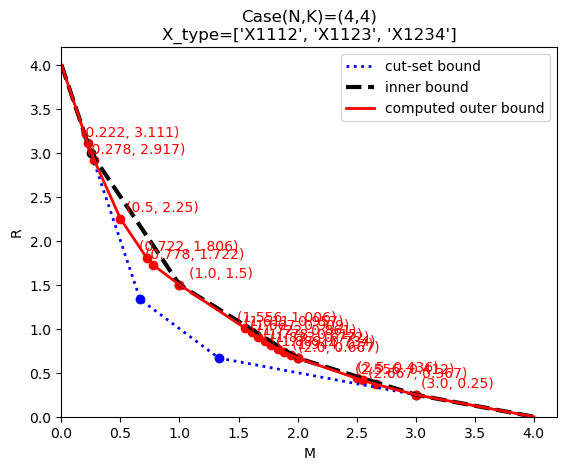

[0.0, 0.05555555555555555, 0.1111111111111111, 0.16666666666666666, 0.2222222222222222, 0.2777777777777778, 0.3333333333333333, 0.38888888888888884, 0.4444444444444444, 0.5, 0.5555555555555556, 0.611111111111111, 0.6666666666666666, 0.7222222222222222, 0.7777777777777777, 0.8333333333333333, 0.8888888888888888, 0.9444444444444444, 1.0, 1.0555555555555556, 1.1111111111111112, 1.1666666666666665, 1.222222222222222, 1.2777777777777777, 1.3333333333333333, 1.3888888888888888, 1.4444444444444444, 1.5, 1.5555555555555554, 1.611111111111111, 1.6666666666666665, 1.722222222222222, 1.7777777777777777, 1.8333333333333333, 1.8888888888888888, 1.9444444444444444, 2.0, 2.0555555555555554, 2.111111111111111, 2.1666666666666665, 2.2222222222222223, 2.2777777777777777, 2.333333333333333, 2.388888888888889, 2.444444444444444, 2.5, 2.5555555555555554, 2.611111111111111, 2.6666666666666665, 2.722222222222222, 2.7777777777777777, 2.833333333333333, 2.888888888888889, 2.944444444444444, 3.0, 3.055555555555

In [162]:
import matplotlib.pyplot as plt

Iutils.plot_cutset_bound(N,K,point_num)
Iutils.plot_inner_bound(N,K)

x = [item[0] for item in plot_data]
y = [item[1] for item in plot_data]
result_slope = Iutils.compute_slopes(x,y)
print(result_slope)
point_x = []
point_y = []
for i in range(1,len(result_slope)):
    if result_slope[i-1] != result_slope[i]:
        point_x.append(x[i])
        point_y.append(y[i])
plt.scatter(point_x,point_y,color="red")

for xi, yi in zip(point_x, point_y):
    label = f"({round(xi,3)}, {round(yi,3)})"
    plt.annotate(label,  
                (xi, yi),  
                textcoords="offset points",  
                xytext=(30, 5),  
                ha='center',
                color='red')  
plt.plot(x, y, color='red', linewidth=2, label='computed outer bound')


plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel("M")
plt.ylabel("R")
plt.legend()
plt.title(f"Case(N,K)=({N},{K})\nX_type={X_combinations}")
plt.show()

print(x)
print(y)

In [163]:
print("number of effective exprs:",len(effective_idx_cut))
for expr in new_regions.exprs:
    print(expr)
# print("effective vars",vars)
print("len of effecitve vars",len(count_dict_all))
count_dict_all = sorted(count_dict_all.items(), key=lambda item: item[1],reverse=True)
count_dict_all = dict(count_dict_all)
print(count_dict_all)

number of effective exprs: 310
2H({W1,Z2,Z3,X1234}) - H({Z1,Z2,X1234}) - H({W1,W2,W3,W4}) >= 0.0
H({W1,Z1,Z2}) + H({Z1,Z2,Z3}) - H({Z1,Z2}) - H({W1,Z1,Z2,Z3}) >= 0.0
H({Z1,Z2,Z3,X1234}) - H({W1,Z2,Z3,X1234}) >= 0.0
2H({Z1}) - H({Z1,Z2}) >= 0.0
2H({Z1,Z2}) - H({Z1}) - H({Z1,Z2,Z3}) >= 0.0
H({Z1}) + H({X1234}) - H({Z1,X1234}) >= 0.0
H({Z1,Z2}) + H({Z1,X1234}) - H({Z1}) - H({Z1,Z2,X1234}) >= 0.0
H({Z1,Z2,X1234}) + H({W1,Z1,Z2,Z3}) - H({W1,Z1,Z2}) - H({Z1,Z2,Z3,X1234}) >= 0.0
2H({W1,W2,W3,Z1}) - H({W1,W2,W3}) - H({W1,W2,W3,Z1,Z2}) >= 0.0
2H({W1,Z2,Z3,X1234}) - H({W1,W2,Z3,X1234}) - H({Z1,Z2,Z3,X1234}) >= 0.0
H({Z1}) + H({X1123}) - H({Z1,X1123}) >= 0.0
H({W1,W2,Z3,X1234}) + H({W1,W2,W3,Z1,Z2}) - H({W1,W2,W3,W4}) - H({W1,W2,W3,Z1}) >= 0.0
H({Z1,Z2}) + H({Z1,X1123}) - H({Z1}) - H({Z1,Z3,X1123}) >= 0.0
H({Z1,Z3,X1123}) + H({W1,Z1,Z2,Z3}) - H({W1,Z1,Z2}) - H({Z1,Z3,Z4,X1123}) >= 0.0
H({Z1,Z3,Z4,X1123}) + H({Z1,Z3,X1123,X1234}) - H({W1,W2,W3,W4}) - H({W2,Z1,Z4,X1123}) >= 0.0
H({W1,Z2,Z3,X1234}) 